In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 11 08:46:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    48W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<!-- f = open("D:\Anna_dataset_classif\ggg.txt", "r")print(f.read())  -->

### Разбитие файлов по папкам train, test, val

In [ ]:
!pip3 install split-folders

In [ ]:
without_trash = 'D:\Anna_dataset_classif\without_trash/'
with_trash = 'D:\Anna_dataset_classif\with_trash'

In [ ]:
import splitfolders
# разбиваем датасет на папки с процентным соотношением числа файлов
# внутри обязательно должны быть папки class1 class2
splitfolders.ratio("D:\Anna_dataset_classif",output='without_trash_split', ratio = (0.65, 0.2, 0.15), seed=13)

Copying files: 893 files [00:04, 204.54 files/s]


### Перевести из bmp to jpg

In [ ]:
from PIL import Image
import os

os.chdir('D:\\Anna_dataset\\Anna_dataset_split\\val\\class2') # поменяем директорию на ту, где у нас расположены картинки

for fname in os.listdir(os.getcwd()): # os.listdir - соответственно, есть ли что-нибудь, у нас, в папке,
    Image.open(fname).save(os.path.splitext(fname)[0]+'.jpg') # а os.getcwd() - папка, в которую мы однажды перешли

### Создать csv с обозначением фото и леблов

In [5]:
import os
import pandas as pd
from torchvision.io import read_image
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
train_data = 'D:\Anna_dataset\Anna_dataset_split/train'
test_data = 'D:\Anna_dataset\Anna_dataset_split/test'
valid_data = 'D:\Anna_dataset\Anna_dataset_split/val'

class_name = ['class1', 'class2']
label_list = []
img_name = []
for i in class_name:
    if i == 'class1':#с объектами
        folder_path = os.path.join(train_data, i)
        img_name_1 = os.listdir(folder_path)
        img_name.extend(img_name_1)
        for i in range(len(img_name_1)):  
            label_list.append(1)
        
    elif i == 'class2':#без
        folder_path = os.path.join(train_data, i)
        img_name_0 = os.listdir(folder_path)
        img_name.extend(img_name_0)
        for i in range(len(img_name_0)):  
            label_list.append(0)


In [ ]:
#create dataframe
data_label = pd.DataFrame({
    'image_name': img_name,
    'label':label_list
})

In [ ]:
from glob import glob
file_path = 'D:\Anna_dataset\Anna_dataset_split\dataset_train.csv'
data_label.to_csv(file_path, mode = 'a',header=not os.path.exists(file_path))
print(data_label)

                      image_name  label
0    Image_20230429174606870.jpg      1
1    Image_20230429174606968.jpg      1
2    Image_20230429174607027.jpg      1
3    Image_20230429174609002.jpg      1
4    Image_20230429174609028.jpg      1
..                           ...    ...
517   Image_0001682634755681.jpg      0
518   Image_0001682634755729.jpg      0
519   Image_0001682634755741.jpg      0
520   Image_0001682634755753.jpg      0
521   Image_0001682634755831.jpg      0

[522 rows x 2 columns]


### Unzip

In [7]:
from zipfile import ZipFile
# /content/drive/MyDrive/for_colab/dataset_segmentation/img_mask_train.zip
with ZipFile('/content/drive/MyDrive/CV/JPG_classif/comb_files.zip', 'r') as zipObj:
   zipObj.extractall('/content/drive/MyDrive/CV/JPG_classif/') 

### Create dataset

In [6]:
import torchvision.transforms as transforms

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.CenterCrop(200),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
class CustomImageDataset:
    def __init__(self, img_dir, annotations_file, transform=None,type_train=None):
        self.data = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.type = type_train
        # converting column data to list
        self.image_name = self.data['image_name'].tolist()
        self.label = self.data['label'].tolist()
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        if self.type == 'train':
            # path = 'D:/Anna_dataset/comb_files/train'
            path = '/content/drive/MyDrive/CV/JPG_classif/train'
        if self.type == 'valid':
            # path = 'D:/Anna_dataset/comb_files/val'
            path = '/content/drive/MyDrive/CV/JPG_classif/val'
        if self.type == 'test':
            # path = 'D:/Anna_dataset/comb_files/test'
            path = '/content/drive/MyDrive/CV/JPG_classif/test'
        folder_path = os.path.join(path, self.image_name[idx])
        image = Image.open(folder_path)
        #image = image.convert('RGB')
        image = image.resize((200,200))
        label = self.label[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
# train_data = 'D:\Anna_dataset/comb_files\train'
# test_data = 'D:\Anna_dataset/comb_files\test'
# valid_data = 'D:\Anna_dataset/comb_files\val'

train_data = '/content/drive/MyDrive/CV/JPG_classif/train'
test_data = '/content/drive/MyDrive/CV/JPG_classif/test'
valid_data = '/content/drive/MyDrive/CV/JPG_classif/val'

# label_train = 'D:\Anna_dataset\Anna_dataset_split\dataset_train.csv'
# label_val = 'D:\Anna_dataset\Anna_dataset_split\dataset_valid.csv'
# label_test = 'D:\Anna_dataset\Anna_dataset_split\dataset_test.csv'

label_train = '/content/drive/MyDrive/CV/JPG_classif/dataset_train.csv'
label_val = '/content/drive/MyDrive/CV/JPG_classif/dataset_valid.csv'
label_test = '/content/drive/MyDrive/CV/JPG_classif/dataset_test.csv'

training_dataset = CustomImageDataset(train_data,label_train,transform, type_train = 'train')
valid_dataset = CustomImageDataset(valid_data, label_val,transform, type_train = 'valid')
test_dataset = CustomImageDataset(valid_data, label_test,transform, type_train = 'test')


In [10]:
import numpy as np
import pandas as pd

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

### Visualization

In [ ]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

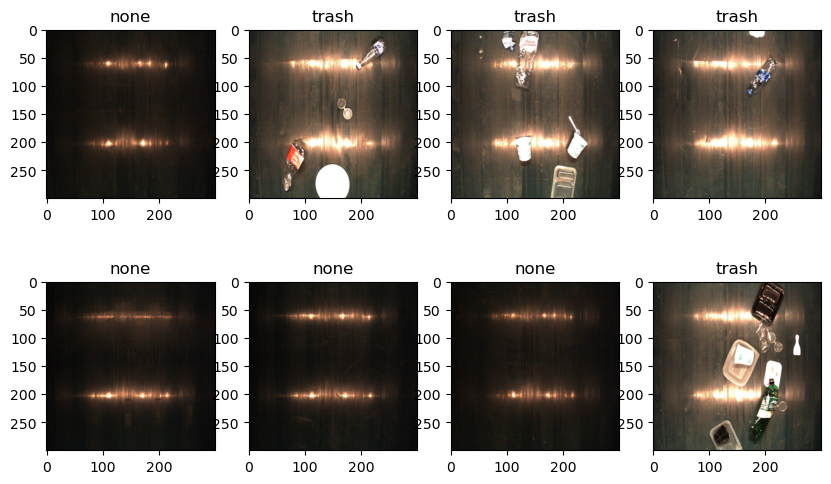

In [ ]:
import matplotlib.pyplot as plt

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
arthopod_types = {0: 'none', 1: 'trash'}
# Viewing data examples used for training
fig, axis = plt.subplots(2, 4, figsize=(10, 6))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

### Model

In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import torchvision.models as models

In [13]:
torch.manual_seed(0xC0FFEE)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
# Before CNN definition, let's check the sizing of input tensor
data, label = next(iter(train_dataloader))
print(data.size())
print(label.size())

torch.Size([16, 3, 200, 200])
torch.Size([16])


In [15]:
clf = models.resnet34(pretrained = False)
clf.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    )
clf.maxpool = torch.nn.Identity()
clf = clf.to('cuda')
opt = torch.optim.SGD(clf.parameters(),  lr=0.001, momentum=0.9, nesterov=True,)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
def epoch_train(loader, clf, criterion, opt):
    # BEGIN Solution (do not delete this comment!)
    avg_loss = 0
    avg_acc = 0
    clf.train(True)

    for batch, (X, y) in enumerate(loader):
        opt.zero_grad()
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = clf(X)
        loss = criterion(pred, y)
        # Backpropagation
        
        loss.backward()
        opt.step()
      
        y_pred = torch.argmax(pred, dim=1)

        avg_loss += loss.item() * X.shape[0] 
        avg_acc += (y_pred == y).sum().item()

    return avg_loss / len(loader.dataset), avg_acc / len(loader.dataset)

    # END Solution (do not delete this comment!)

def epoch_test(loader, clf, criterion):
    # BEGIN Solution (do not delete this comment!)

    clf.eval()
    avg_loss, avg_acc = 0, 0

    for batch,(X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)
        pred = clf(X)
        loss = criterion(pred, y)

        y_pred = torch.argmax(pred, dim=1)

        avg_loss += loss.item() * X.shape[0]
        avg_acc += (y_pred == y).sum().item()
    
    return avg_loss / len(loader.dataset), avg_acc / len(loader.dataset)

    # END Solution (do not delete this comment!)

# The function which you are going to use for model training
def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.3f}; ' + 
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.3f}')


In [48]:
train(train_dataloader, val_dataloader, clf, criterion, opt, n_epochs=5)

 20%|██        | 1/5 [00:26<01:44, 26.09s/it]

[Epoch 1] train loss: 0.002; train acc: 1.000; test loss: 0.000; test acc: 1.000


 40%|████      | 2/5 [00:52<01:18, 26.08s/it]

[Epoch 2] train loss: 0.004; train acc: 1.000; test loss: 0.000; test acc: 1.000


 60%|██████    | 3/5 [01:18<00:52, 26.10s/it]

[Epoch 3] train loss: 0.002; train acc: 1.000; test loss: 0.000; test acc: 1.000


 80%|████████  | 4/5 [01:44<00:26, 26.06s/it]

[Epoch 4] train loss: 0.001; train acc: 1.000; test loss: 0.000; test acc: 1.000


100%|██████████| 5/5 [02:10<00:00, 26.05s/it]

[Epoch 5] train loss: 0.004; train acc: 1.000; test loss: 0.000; test acc: 1.000


In [19]:
torch.save(clf.state_dict(), '/content/drive/MyDrive/CV/JPG_classif/weight_model.pth')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = '/content/drive/MyDrive/CV/JPG_classif/weight_model.pth'
clf.load_state_dict(torch.load(file_path))
clf.eval()

### Predict

In [82]:
def predict(img, model):
    img = transform(img).to(device)
    img = torch.unsqueeze(img, 0)
    yhat = model(img)
    index = yhat.data.cpu().numpy().argmax()
    # prediction = yhat.argmax()

    return index   

In [27]:
from torchvision import datasets, transforms, models

In [30]:
def get_random_images(num):
    data_dir = '/content/drive/MyDrive/CV/JPG_classif/test'
    data = datasets.ImageFolder(data_dir, transform=transform)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

### Test

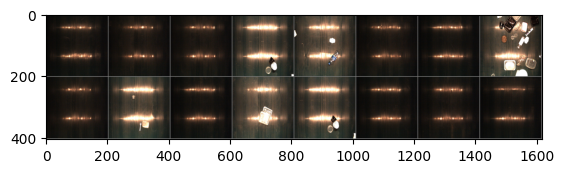

    0     0     0     1     1     0     0     1
    0     1     0     1     1     0     0     0


In [98]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(test_dataloader)
# images, labels = dataiter.next()
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
classes = ['0','1']
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))
print(' '.join('%5s' % classes[labels[j]] for j in range(8,16,1)))

In [99]:
images = images.to(device)
outputs = clf(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ')
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))
print(' '.join('%5s' % classes[labels[j]] for j in range(8,16,1)))

Predicted: 
    0     0     0     1     1     0     0     1
    0     1     0     1     1     0     0     0


In [108]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
     for data in test_dataloader:
         images, labels = data
         images = images.to(device)
         labels = labels.to(device)
         clf = clf.to(device)
         outputs = clf(images)
         _, predicted = torch.max(outputs, 1)
         c = (predicted == labels).squeeze()
         for i in range(3):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1
for i in range(10):
     print('Accuracy of %5s : %2d %%' % ( classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %


IndexError: ignored

### Удалить изображения, которые не содержат мусор 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = '/content/drive/MyDrive/CV/JPG_classif/weight_model.pth'
clf.load_state_dict(torch.load(file_path))
clf.eval()

In [110]:
def predict(img, model):
    img = transform(img).to(device)
    img = torch.unsqueeze(img, 0)
    yhat = model(img)
    index = yhat.data.cpu().numpy().argmax()

    return index  

In [ ]:
import os
from os import listdir
import time

list_images = [] #если изображение будет уже в списке, не будем делать предсказания и пропускаем
while True:
  folder_dir = "/content/drive/MyDrive/CV/JPG_classif/test2"
  for images in os.listdir(folder_dir):
      if images not in list_images:
        list_images.append(images)
        file_path = os.path.join(folder_dir, images)
        image = Image.open(file_path)
        image = image.resize((200,200))
        label = predict(image,clf)
        if label == 0:
          os.remove(file_path)
        else:
          pass
      else:
        continue 

  time.sleep(10)